In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

# ===============================
# File paths
# ===============================

doh_tunnel_iodine = "/home/ubuntu/DoH_DGA_training/datasets/PCAPs/DoHMalicious/iodine/all_pcaps_allN.csv"
doh_tunnel_dns2tcp = "/home/ubuntu/DoH_DGA_training/datasets/PCAPs/DoHMalicious/dns2tcp/all_pcaps_allN.csv"
doh_tunnel_dnscat2 = "/home/ubuntu/DoH_DGA_training/datasets/PCAPs/DoHMalicious/dnscat2/all_pcaps_allN.csv"

dga_malware_google = "/home/ubuntu/DoH_DGA_training/datasets/DGA_Google/all_pcaps_allN.csv"
dga_malware_clouflare = "/home/ubuntu/DoH_DGA_training/datasets/DGA_CF/all_pcaps_allN.csv"
dga_malware_adguard = "/home/ubuntu/DoH_DGA_training/datasets/DGA_ADGuard/all_pcaps_allN.csv"
dga_malware_quad9 = "/home/ubuntu/DoH_DGA_training/datasets/DGA_Quad9/all_pcaps_allN.csv"

nondoh_benign_file = "/home/ubuntu/DoH_DGA_training/datasets/PCAPs/DoHBenign-NonDoH/all_nondoh.csv"

doh_benign_file = "/home/ubuntu/DoH_DGA_training/datasets/PCAPs/DoHBenign-NonDoH/all_doh.csv"

# ===============================
# Load datasets
# ===============================
df_doh_tunnel_iodine = pd.read_csv(doh_tunnel_iodine)
df_doh_tunnel_dns2tcp = pd.read_csv(doh_tunnel_dns2tcp)
df_doh_tunnel_dnscat2 = pd.read_csv(doh_tunnel_dnscat2)
df_doh_tunnel = pd.concat([df_doh_tunnel_iodine, df_doh_tunnel_dns2tcp, df_doh_tunnel_dnscat2], ignore_index=True)

df_dga_google = pd.read_csv(dga_malware_google)
df_dga_clouflare = pd.read_csv(dga_malware_clouflare)
df_dga_adguard = pd.read_csv(dga_malware_adguard)
df_dga_quad9 = pd.read_csv(dga_malware_quad9)
df_dga = pd.concat([df_dga_google, df_dga_clouflare, df_dga_adguard, df_dga_quad9], ignore_index=True)

df_nondoh_benign = pd.read_csv(nondoh_benign_file)
df_doh_benign = pd.read_csv(doh_benign_file)

# ===============================
# Assign labels
# ===============================
df_dga["label"] = "DGA"
df_doh_tunnel["label"] = "DoH_Tunnel"
df_nondoh_benign["label"] = "NonDoH_Benign"
df_doh_benign["label"] = "DoH_Benign"

# ===============================
# Combine all into one DataFrame
# ===============================
df_all = pd.concat(
    [df_dga, df_doh_tunnel, df_nondoh_benign, df_doh_benign, df_doh_benign],
    ignore_index=True
)


print("DGA_shape:", df_dga.shape)
print("DoH_Tunnel shape:", df_doh_tunnel.shape)
print("NonDoH_Benign shape:", df_nondoh_benign.shape)
print("DoH_Benign shape:", df_doh_benign.shape)

print("\nFinal dataset shape:", df_all.shape)
print("Labels distribution:\n", df_all["label"].value_counts())
print("Columns:\n", list(df_all.columns))


DGA_shape: (406808, 35)
DoH_Tunnel shape: (707228, 35)
NonDoH_Benign shape: (2139204, 36)
DoH_Benign shape: (116412, 36)

Final dataset shape: (3486064, 36)
Labels distribution:
 label
NonDoH_Benign    2139204
DoH_Tunnel        707228
DGA               406808
DoH_Benign        232824
Name: count, dtype: int64
Columns:
 ['session_id', 'client_ip', 'server_ip', 'client_port', 'server_port', 'protocol', 'N', 'n_client', 'client_bytes', 'client_pkt_min', 'client_pkt_mean', 'client_pkt_max', 'client_iat_min', 'client_iat_mean', 'client_iat_max', 'n_server', 'server_bytes', 'server_pkt_min', 'server_pkt_mean', 'server_pkt_max', 'server_iat_min', 'server_iat_mean', 'server_iat_max', 'pkt_fraction_client', 'bytes_fraction_client', 'flow_duration', 'time_first_response', 'dir_switches', 'size_min', 'size_mean', 'size_max', 'iat_min', 'iat_mean', 'iat_max', 'label', 'source_pcap']


In [2]:
N_value = 16   # <-- change this to 8, 16, 32, 64 as needed
df_subset = df_all[df_all["N"] == N_value].copy()

print(f"\nTraining on N={N_value}, dataset size={df_subset.shape[0]}")

# Separate features and target
y = df_subset["label"]
X = df_subset.drop(columns=[
    "label", 'session_id', 'client_ip', 'server_ip', 
    'client_port', 'server_port', 'protocol', 'N',
    'pcap_file', 'source_pcap'
], errors="ignore")
feature_names = X.columns.tolist()
# Keep only numeric features
X = X.select_dtypes(include=["int64", "float64"])

print("Remaining feature columns:\n", list(X.columns))
print("Target classes:", y.unique())


Training on N=16, dataset size=871516
Remaining feature columns:
 ['n_client', 'client_bytes', 'client_pkt_min', 'client_pkt_mean', 'client_pkt_max', 'client_iat_min', 'client_iat_mean', 'client_iat_max', 'n_server', 'server_bytes', 'server_pkt_min', 'server_pkt_mean', 'server_pkt_max', 'server_iat_min', 'server_iat_mean', 'server_iat_max', 'pkt_fraction_client', 'bytes_fraction_client', 'flow_duration', 'time_first_response', 'dir_switches', 'size_min', 'size_mean', 'size_max', 'iat_min', 'iat_mean', 'iat_max']
Target classes: ['DGA' 'DoH_Tunnel' 'NonDoH_Benign' 'DoH_Benign']


In [3]:
# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.3, random_state=42, stratify=y_enc
)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
# Train MLP
# Extended MLP with more options
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),   # deeper network with 3 hidden layers
    activation="relu",                  # alternatives: 'tanh', 'logistic'
    solver="adam",                      # alternatives: 'sgd', 'lbfgs'
    alpha=1e-4,                         # L2 regularization (weight decay)
    batch_size=64,                      # mini-batch size
    learning_rate="adaptive",           # 'constant', 'invscaling', 'adaptive'
    learning_rate_init=0.001,           # initial learning rate
    max_iter=500,                       # train longer
    shuffle=True,                       # shuffle samples every epoch
    early_stopping=True,                # stop if validation score doesn’t improve
    validation_fraction=0.1,            # use 10% of training for validation
    n_iter_no_change=20,                # patience for early stopping
    random_state=42,                    # reproducibility
    verbose=True                        # print progress during training
)

mlp.fit(X_train, y_train)

# Evaluate
y_pred = mlp.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))

Iteration 1, loss = 0.08572994
Validation score: 0.990935
Iteration 2, loss = 0.03535188
Validation score: 0.992853
Iteration 3, loss = 0.02905563
Validation score: 0.990362
Iteration 4, loss = 0.02545175
Validation score: 0.990870
Iteration 5, loss = 0.02327134
Validation score: 0.991050
Iteration 6, loss = 0.02190873
Validation score: 0.991952
Iteration 7, loss = 0.01990571
Validation score: 0.995837
Iteration 8, loss = 0.01877779
Validation score: 0.995837
Iteration 9, loss = 0.01905909
Validation score: 0.996050
Iteration 10, loss = 0.01788717
Validation score: 0.996230
Iteration 11, loss = 0.01690730
Validation score: 0.992952
Iteration 12, loss = 0.01668748
Validation score: 0.996886
Iteration 13, loss = 0.01549760
Validation score: 0.997050
Iteration 14, loss = 0.01683231
Validation score: 0.996836
Iteration 15, loss = 0.01555591
Validation score: 0.996230
Iteration 16, loss = 0.01500748
Validation score: 0.996886
Iteration 17, loss = 0.01371384
Validation score: 0.993591
Iterat

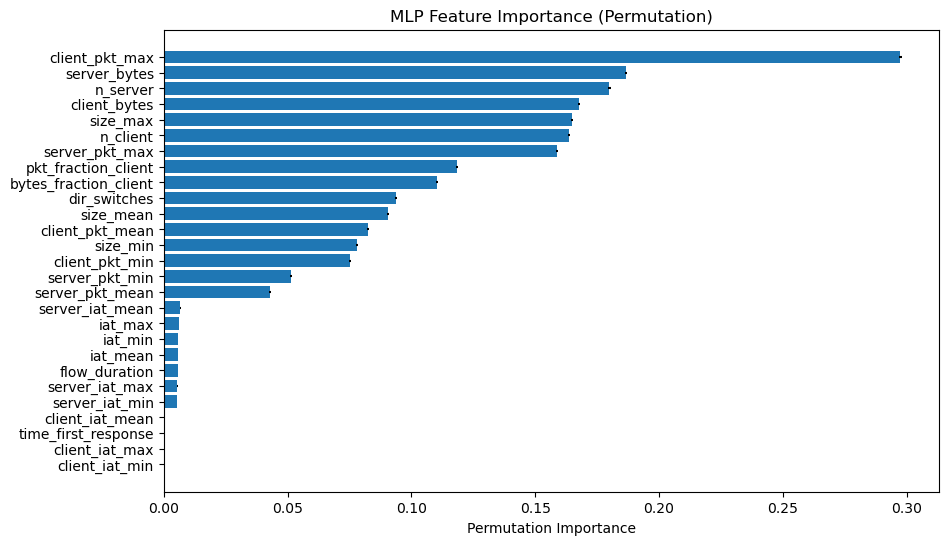

In [5]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import numpy as np
# --- Create generic feature names ---
#feature_names = [f"f{i}" for i in range(X_train.shape[1])]

# Compute permutation importance on test set
result = permutation_importance(
    mlp, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Sort by importance
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(
    range(len(sorted_idx)), 
    result.importances_mean[sorted_idx], 
    xerr=result.importances_std[sorted_idx]
)
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("MLP Feature Importance (Permutation)")
plt.show()


In [6]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Use a small background set for SHAP (to speed up kernel explainer)
background = shap.utils.sample(X_train, 200, random_state=42)

# Create SHAP Kernel Explainer (model-agnostic, works for sklearn MLP)
explainer = shap.KernelExplainer(mlp.predict_proba, background)

# Explain predictions on a sample of test set (to save time)
X_sample = shap.utils.sample(X_test, 300, random_state=42)

# Compute shap values (multiclass: list of arrays, one per class)
shap_values = explainer.shap_values(X_sample)


/home/ubuntu/miniconda/envs/jupyterenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 300/300 [01:21<00:00,  3.70it/s]


client_pkt_max           0.065881
server_bytes             0.037916
size_max                 0.026725
server_pkt_max           0.025596
client_bytes             0.025480
n_server                 0.023549
n_client                 0.022336
bytes_fraction_client    0.014775
client_pkt_mean          0.013593
client_pkt_min           0.013205
pkt_fraction_client      0.012457
dir_switches             0.010522
size_mean                0.009675
server_pkt_min           0.008368
size_min                 0.007462
server_pkt_mean          0.005396
iat_max                  0.001676
server_iat_mean          0.001447
server_iat_max           0.001309
flow_duration            0.001255
iat_mean                 0.000940
iat_min                  0.000897
server_iat_min           0.000796
client_iat_mean          0.000181
time_first_response      0.000107
client_iat_min           0.000076
client_iat_max           0.000071
dtype: float64


<Axes: title={'center': 'Mean |SHAP| across samples & classes'}>

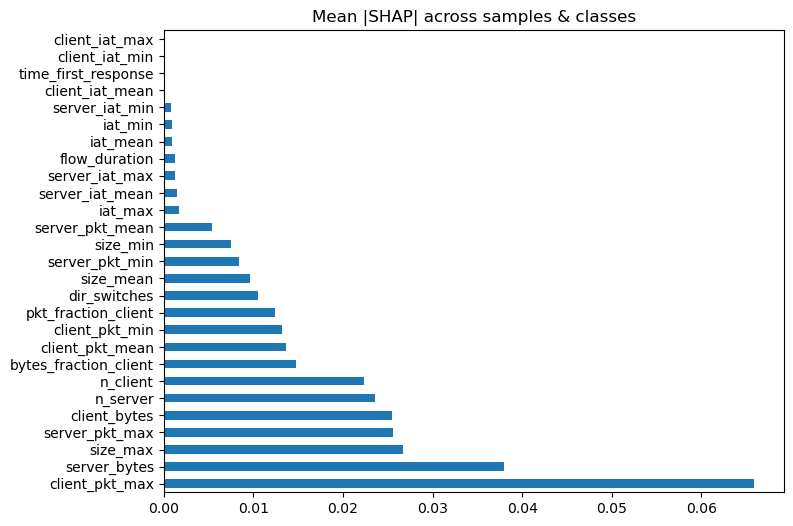

In [7]:
# mean absolute shap across samples and classes -> (n_features,)
mean_abs_shap_per_feat = np.mean(np.abs(shap_values), axis=(0, 2))

# build a pandas Series for display/sorting
import pandas as pd
features = X.columns.tolist()
feat_imp = pd.Series(mean_abs_shap_per_feat, index=features).sort_values(ascending=False)
print(feat_imp)

# bar plot of top 16 (or top N)
feat_imp.plot(kind='barh', figsize=(8,6), title="Mean |SHAP| across samples & classes")

In [8]:
import pandas as pd
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test  = pd.DataFrame(X_test,  columns=feature_names)
# Rank features
importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)
# Select top 16
top_features = importances.head(16).index.tolist()
print("Top 16 features:", top_features)

Top 16 features: ['client_pkt_max', 'server_bytes', 'n_server', 'client_bytes', 'size_max', 'n_client', 'server_pkt_max', 'pkt_fraction_client', 'bytes_fraction_client', 'dir_switches', 'size_mean', 'client_pkt_mean', 'size_min', 'client_pkt_min', 'server_pkt_min', 'server_pkt_mean']


# RE TRAINING WITH REDUCED MODEL

In [15]:
N_value = 16   # <-- change this to 8, 16, 32, 64 as needed
df_subset = df_all[df_all["N"] == N_value].copy()

print(f"\nTraining on N={N_value}, dataset size={df_subset.shape[0]}")

# Separate features and target
y = df_subset["label"]
X = df_subset.drop(columns=[
    "label", 'session_id', 'client_ip', 'server_ip', 
    'client_port', 'server_port', 'protocol', 'N',
    'pcap_file', 'source_pcap'
], errors="ignore")

feature_names = X.columns.tolist()
# Keep only numeric features
X = X.select_dtypes(include=["int64", "float64"])

print("Remaining feature columns:\n", list(X.columns))
print("Target classes:", y.unique())

# --- Select top features based on importance ---
top_features = importances.head(16).index.tolist()
print("Top 16 selected features:", top_features)

# Keep only those top features
X = X[top_features]
print(f"Final feature matrix shape: {X.shape}")


Training on N=16, dataset size=871516
Remaining feature columns:
 ['n_client', 'client_bytes', 'client_pkt_min', 'client_pkt_mean', 'client_pkt_max', 'client_iat_min', 'client_iat_mean', 'client_iat_max', 'n_server', 'server_bytes', 'server_pkt_min', 'server_pkt_mean', 'server_pkt_max', 'server_iat_min', 'server_iat_mean', 'server_iat_max', 'pkt_fraction_client', 'bytes_fraction_client', 'flow_duration', 'time_first_response', 'dir_switches', 'size_min', 'size_mean', 'size_max', 'iat_min', 'iat_mean', 'iat_max']
Target classes: ['DGA' 'DoH_Tunnel' 'NonDoH_Benign' 'DoH_Benign']
Top 16 selected features: ['client_pkt_max', 'server_bytes', 'n_server', 'client_bytes', 'size_max', 'n_client', 'server_pkt_max', 'pkt_fraction_client', 'bytes_fraction_client', 'dir_switches', 'size_mean', 'client_pkt_mean', 'size_min', 'client_pkt_min', 'server_pkt_min', 'server_pkt_mean']
Final feature matrix shape: (871516, 16)


In [16]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.3, random_state=42, stratify=y_enc
)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
 #Train MLP
# Extended MLP with more options
mlp_reduced = MLPClassifier(
    hidden_layer_sizes=(64, 32),   # deeper network with 3 hidden layers
    activation="relu",                  # alternatives: 'tanh', 'logistic'
    solver="adam",                      # alternatives: 'sgd', 'lbfgs'
    alpha=1e-4,                         # L2 regularization (weight decay)
    batch_size=64,                      # mini-batch size
    learning_rate="adaptive",           # 'constant', 'invscaling', 'adaptive'
    learning_rate_init=0.001,           # initial learning rate
    max_iter=500,                       # train longer
    shuffle=True,                       # shuffle samples every epoch
    early_stopping=True,                # stop if validation score doesn’t improve
    validation_fraction=0.1,            # use 10% of training for validation
    n_iter_no_change=20,                # patience for early stopping
    random_state=42,                    # reproducibility
    verbose=True                        # print progress during training
)

mlp_reduced.fit(X_train, y_train)

# Evaluate
y_pred = mlp_reduced.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))

Iteration 1, loss = 0.08112431
Validation score: 0.987477
Iteration 2, loss = 0.03555349
Validation score: 0.993738
Iteration 3, loss = 0.03021493
Validation score: 0.989870
Iteration 4, loss = 0.02681739
Validation score: 0.994361
Iteration 5, loss = 0.02454248
Validation score: 0.995525
Iteration 6, loss = 0.02347469
Validation score: 0.991968
Iteration 7, loss = 0.02161671
Validation score: 0.995902
Iteration 8, loss = 0.02029275
Validation score: 0.994410
Iteration 9, loss = 0.01913685
Validation score: 0.995853
Iteration 10, loss = 0.01724940
Validation score: 0.996214
Iteration 11, loss = 0.01835608
Validation score: 0.996066
Iteration 12, loss = 0.01676600
Validation score: 0.991804
Iteration 13, loss = 0.01578768
Validation score: 0.996197
Iteration 14, loss = 0.01561510
Validation score: 0.996443
Iteration 15, loss = 0.01478602
Validation score: 0.993853
Iteration 16, loss = 0.01517933
Validation score: 0.997213
Iteration 17, loss = 0.01448727
Validation score: 0.996853
Iterat

<Figure size 1000x800 with 0 Axes>

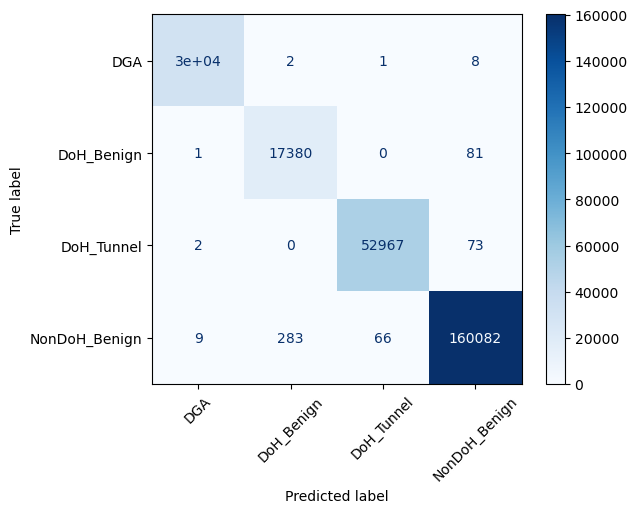

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.show()

In [25]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Take only the top features you trained with
X_train_reduced = X_train
X_test_reduced  = X_test

# Use a small background set for SHAP (to speed up kernel explainer)
background = shap.utils.sample(X_train_reduced, 200, random_state=42)

# Create SHAP Kernel Explainer (model-agnostic, works for sklearn MLP)
explainer = shap.KernelExplainer(mlp_reduced.predict_proba, background)

# Explain predictions on a sample of test set (to save time)
X_sample = shap.utils.sample(X_test_reduced, 300, random_state=42)

# Compute shap values (multiclass: list of arrays, one per class)
shap_values = explainer.shap_values(X_sample)


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 300/300 [01:11<00:00,  4.20it/s]


client_pkt_max           0.063807
server_bytes             0.041675
n_server                 0.032587
server_pkt_max           0.027192
client_bytes             0.023160
size_max                 0.019877
n_client                 0.019003
pkt_fraction_client      0.016234
size_mean                0.014932
bytes_fraction_client    0.014317
dir_switches             0.013905
size_min                 0.012618
server_pkt_mean          0.012201
client_pkt_min           0.011290
server_pkt_min           0.008909
client_pkt_mean          0.008711
dtype: float64


<Axes: title={'center': 'Mean |SHAP| across samples & classes'}>

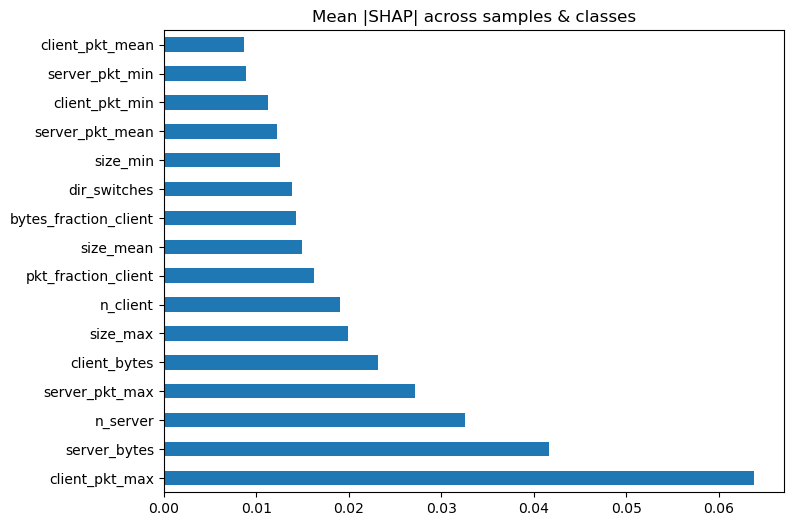

In [26]:

# mean absolute shap across samples and classes -> (n_features,)
mean_abs_shap_per_feat = np.mean(np.abs(shap_values), axis=(0, 2))

# build a pandas Series for display/sorting
import pandas as pd
feat_imp = pd.Series(mean_abs_shap_per_feat, index=top_features).sort_values(ascending=False)
print(feat_imp)

# bar plot of top 16 (or top N)
feat_imp.head(16).plot(kind='barh', figsize=(8,6), title="Mean |SHAP| across samples & classes")


Class: DGA


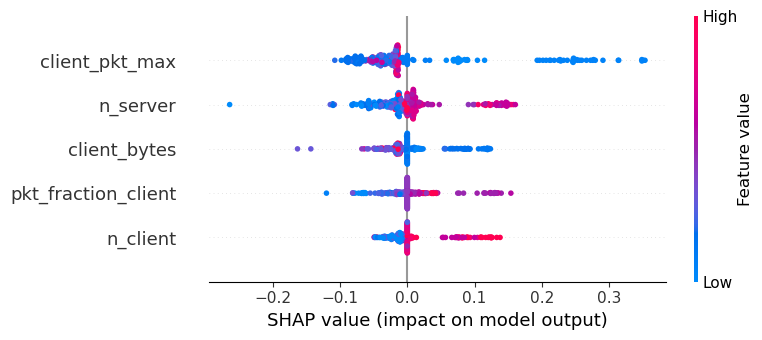

Class: DoH_Benign


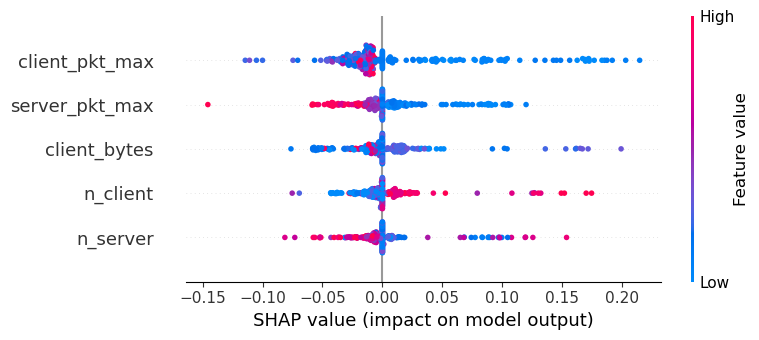

Class: DoH_Tunnel


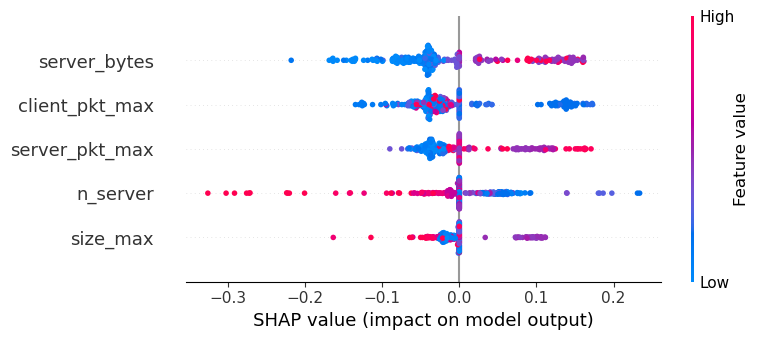

Class: NonDoH_Benign


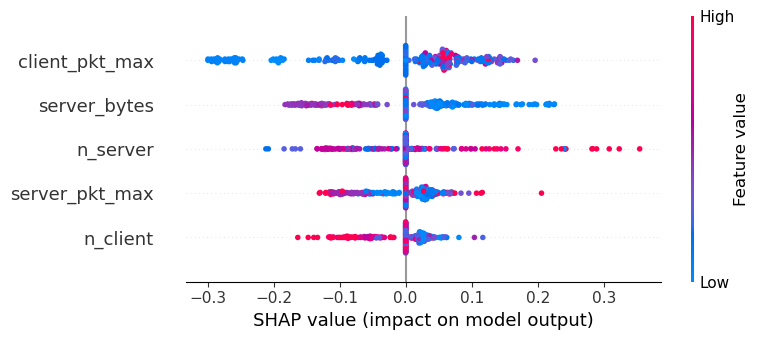

In [27]:
import matplotlib.pyplot as plt

for i, cname in enumerate(le.classes_):
    print("Class:", cname)
    shap.summary_plot(shap_values[:, :, i], X_sample, feature_names=top_features, show=True, max_display=5)


# Export model reduced form

In [29]:
import os
import numpy as np
from sklearn.preprocessing import StandardScaler

output_folder = "./mlp_multi_models"
os.makedirs(output_folder, exist_ok=True)

# --- Adjust these to match your environment ----
# 1) If you used a pipeline similar to your example, set pipe = results["pipeline"]
pipe = None               # <-- set this if you have a pipeline object
# 2) If you trained the MLP directly, ensure mlp_reduced is available in the namespace
mlp = mlp_reduced                # <-- will be set below
# 3) Provide the scaler if you used it standalone, or let the script extract it from the pipeline
scaler = scaler            # <-- set to your StandardScaler instance if not using a pipeline
# 4) Provide your feature list (order must match training columns used)
#    If you used top_features when fitting, set feature_cols = top_features
feature_cols = top_features       # <-- e.g. feature_cols = list(top_features) or results["feature_cols"]

# ----------------- Helper: write arrays to C -----------------
def write_array_to_c(name, array, f, add_f_suffix=False):
    shape = array.shape
    flat  = array.flatten()
    f.write(f"// Shape: {shape}\n")
    f.write(f"static const float {name}[{len(flat)}] ALIGN16 = {{\n    ")
    if add_f_suffix:
        f.write(", ".join(f"{float(x):.6f}f" for x in flat))
    else:
        f.write(", ".join(f"{float(x):.6f}" for x in flat))
    f.write("\n};\n\n")

def export_mlp_to_c(model, out_path):
    with open(out_path, "w") as f:
        f.write("// Auto-generated MLP weights + pointers for C inference\n")
        f.write("// Generated from scikit-learn MLPClassifier\n\n")
        f.write("#pragma once\n\n")
        f.write("#define ALIGN16 __attribute__((aligned(16)))\n\n")

        n_layers = len(model.coefs_)  # number of weight matrices (hidden layers + output)
        f.write(f"#define NUM_LAYERS {n_layers}\n\n")
        # number of outputs = neurons in final layer
        output_size = model.coefs_[-1].shape[1]

        # if binary classifier (single output neuron) -> 2 classes
        num_classes = 2 if output_size == 1 else output_size

        f.write(f"#define NUM_CLASSES {num_classes}\n\n")
        in_size = model.coefs_[0].shape[0]
        sizes   = [in_size] + [w.shape[1] for w in model.coefs_]
        f.write("static const int LAYER_SIZES[NUM_LAYERS+1] = { " +
                ", ".join(str(int(s)) for s in sizes) +
                " };\n\n")

        # determine output size (number of outputs from final layer)
        output_size = int(model.coefs_[-1].shape[1])
        f.write(f"#define OUTPUT_SIZE {output_size}\n\n")

        # Write conditional compile flags for binary vs multiclass
        f.write("// Convenience macros for selecting code paths at compile time\n")
        f.write("#if OUTPUT_SIZE == 1\n")
        f.write("    #define IS_BINARY_CLASSIFICATION 1\n")
        f.write("    #define IS_MULTICLASS_CLASSIFICATION 0\n")
        f.write("#else\n")
        f.write("    #define IS_BINARY_CLASSIFICATION 0\n")
        f.write("    #define IS_MULTICLASS_CLASSIFICATION 1\n")
        f.write("#endif\n\n")

        for idx, (W, b) in enumerate(zip(model.coefs_, model.intercepts_)):
            # sklearn W is (size_in, size_out)
            W = W.astype(np.float32, copy=False)
            B = b.astype(np.float32, copy=False)
            write_array_to_c(f"W{idx}", W, f)
            write_array_to_c(f"B{idx}", B, f)

        f.write("// Weight & bias pointers per layer\n")
        f.write("static const float *WEIGHTS[NUM_LAYERS] = { " +
                ", ".join(f"W{j}" for j in range(n_layers)) +
                " };\n")
        f.write("static const float *BIASES[NUM_LAYERS]  = { " +
                ", ".join(f"B{j}" for j in range(n_layers)) +
                " };\n\n")

        f.write("#undef ALIGN16\n")

# ----------------- Determine mlp, scaler, feature names -----------------
# Case A: user provides a pipeline object in variable `pipe`
if pipe is not None:
    try:
        mlp = pipe.named_steps["clf"]
    except Exception:
        raise RuntimeError("Pipeline provided but 'clf' not found in named_steps")

    # try to locate scaler inside a ColumnTransformer inside preproc
    try:
        preproc = pipe.named_steps["preproc"]
        # assumes ColumnTransformer named transformer 'num' containing a pipeline with scaler step named 'scaler'
        scaler = preproc.named_transformers_["num"].named_steps["scaler"]
    except Exception:
        # fallback: look for any StandardScaler in pipeline
        for name, step in preproc.named_steps.items():
            if isinstance(step, StandardScaler):
                scaler = step
                break

# Case B: pipeline not used, user trained `mlp_reduced` directly
if mlp is None:
    # try to use provided mlp_reduced from user's scope
    try:
        mlp = globals().get("mlp_reduced", None) or globals().get("mlp", None)
    except Exception:
        mlp = None

if mlp is None:
    raise RuntimeError("Could not locate trained MLP. Make sure `mlp_reduced` or `pipe` is defined.")

# If scaler not found, maybe user passed a plain StandardScaler variable; if not, attempt to compute mean/std from training data if available
if scaler is None:
    # try to find StandardScaler in globals
    scaler = globals().get("scaler", None)

# If still None, but feature columns & X_train are available, compute scaler from training data (this reproduces what you'd do for inference stats)
if scaler is None:
    X_train = globals().get("X_train", None)
    if X_train is not None and feature_cols is not None:
        print("[WARN] No StandardScaler instance found — computing mean/std from X_train[feature_cols]. This must match the scaler used at training time.")
        tmp_scaler = StandardScaler()
        tmp_scaler.fit(X_train[feature_cols])
        scaler = tmp_scaler
    else:
        raise RuntimeError("No scaler found and cannot compute it (X_train or feature_cols missing). Provide the scaler or set X_train/feature_cols.")

# If feature_cols not provided and you have a pipeline with feature names available in e.g. results dict
if feature_cols is None:
    # try common names used in examples
    feature_cols = globals().get("feature_cols", None) or globals().get("top_features", None)
    if feature_cols is None:
        # try to infer from scaler if it's a named transformer (rare)
        raise RuntimeError("feature_cols is not set. Provide the ordered list of features used to train the model.")

# ----------------- Compute means/stds and safe-guard -----------------
means = scaler.mean_.astype(np.float32)
stds  = scaler.scale_.astype(np.float32)

# safety to avoid divide-by-zero in C inference
stds[stds == 0.0] = 1.0

# ----------------- Export MLP weights -----------------
mlp_header_path = os.path.join(output_folder, "mlp_weights.h")
export_mlp_to_c(mlp, mlp_header_path)
print(f"[OK] Wrote weights to {mlp_header_path}")

# ----------------- Export feature stats header -----------------
feat_header_path = os.path.join(output_folder, "feature_stats.h")
with open(feat_header_path, "w") as f:
    f.write("// Auto-generated feature stats for z-score normalization\n\n")
    f.write("#pragma once\n\n")
    f.write("#define ALIGN16 __attribute__((aligned(16)))\n\n")
    f.write(f"#define NUM_FEATURES {len(means)}\n\n")

    f.write("static const float FEATURE_MEAN[NUM_FEATURES] ALIGN16 = {\n    ")
    f.write(", ".join(f"{float(m):.6f}f" for m in means))
    f.write("\n};\n\n")

    f.write("static const float FEATURE_STD[NUM_FEATURES] ALIGN16 = {\n    ")
    f.write(", ".join(f"{float(s):.6f}f" for s in stds))
    f.write("\n};\n\n")
    f.write("#undef ALIGN16\n")
print(f"[OK] Wrote scaler stats to {feat_header_path}")

# ----------------- Save feature order for verification -----------------
names_txt = os.path.join(output_folder, "feature_names.txt")
with open(names_txt, "w") as f:
    for c in feature_cols:
        f.write(str(c) + "\n")
print(f"[OK] Wrote feature names to {names_txt}")

# ----------------- Sanity print -----------------
print("\n=== Sanity ===")
print("Feature count:", len(feature_cols))
layer_sizes = [mlp.coefs_[0].shape[0]] + [w.shape[1] for w in mlp.coefs_]
print("Layer sizes  :", layer_sizes)
for i, (W, b) in enumerate(zip(mlp.coefs_, mlp.intercepts_)):
    print(f"Layer {i}: W {W.shape}, B {b.shape}")

print("\nAll done — check folder:", output_folder)

[OK] Wrote weights to ./mlp_multi_models/mlp_weights.h
[OK] Wrote scaler stats to ./mlp_multi_models/feature_stats.h
[OK] Wrote feature names to ./mlp_multi_models/feature_names.txt

=== Sanity ===
Feature count: 16
Layer sizes  : [16, 64, 32, 4]
Layer 0: W (16, 64), B (64,)
Layer 1: W (64, 32), B (32,)
Layer 2: W (32, 4), B (4,)

All done — check folder: ./mlp_multi_models


## Debugging flows

In [31]:
N_value = 16
df_subset = df_all[df_all["N"] == N_value].copy()

print(f"\nSubset N={N_value}, dataset size={df_subset.shape[0]}")

# Separate features and target
y = df_subset["label"]
X = df_subset.drop(columns=[
    "label", 'session_id', 'client_ip', 'server_ip', 
    'client_port', 'server_port', 'protocol', 'N',
    'pcap_file', 'source_pcap'
], errors="ignore")

# Keep only numeric features
X = X.select_dtypes(include=["int64", "float64"])
feature_names = X.columns.tolist()

print("Remaining numeric features:", feature_names)
print("Target classes:", y.unique())

# --- Select top features based on importance ---
top_features = importances.head(16).index.tolist()
print("\nTop 16 selected features:", top_features)

# Keep only top 16
X = X[top_features]
df_subset_top = X.copy()
df_subset_top["label"] = y.values  # add back class for printing per class

# Print first 10 flows for each class separately
print("\n=== Example flows per class (N=16) ===")
for cls in sorted(df_subset_top["label"].unique()):
    df_class = df_subset_top[df_subset_top["label"] == cls]
    print(f"\nClass '{cls}' — {len(df_class)} flows")
    print(df_class[top_features].head(10).to_string(index=False))


Subset N=16, dataset size=871516
Remaining numeric features: ['n_client', 'client_bytes', 'client_pkt_min', 'client_pkt_mean', 'client_pkt_max', 'client_iat_min', 'client_iat_mean', 'client_iat_max', 'n_server', 'server_bytes', 'server_pkt_min', 'server_pkt_mean', 'server_pkt_max', 'server_iat_min', 'server_iat_mean', 'server_iat_max', 'pkt_fraction_client', 'bytes_fraction_client', 'flow_duration', 'time_first_response', 'dir_switches', 'size_min', 'size_mean', 'size_max', 'iat_min', 'iat_mean', 'iat_max']
Target classes: ['DGA' 'DoH_Tunnel' 'NonDoH_Benign' 'DoH_Benign']

Top 16 selected features: ['client_pkt_max', 'server_bytes', 'n_server', 'client_bytes', 'size_max', 'n_client', 'server_pkt_max', 'pkt_fraction_client', 'bytes_fraction_client', 'dir_switches', 'size_mean', 'client_pkt_mean', 'size_min', 'client_pkt_min', 'server_pkt_min', 'server_pkt_mean']

=== Example flows per class (N=16) ===

Class 'DGA' — 101702 flows
 client_pkt_max  server_bytes  n_server  client_bytes  si

In [35]:
import ipaddress
import pandas as pd

# --- 5-tuple to find (given by you) ---
src_ip_int  = 2959573634
src_port_val = 443
dst_ip_int  = 3232240831
dst_port_val = 57500
proto_val   = 6

# --- subset settings ---
N_value = 16
df_subset = df_all[df_all["N"] == N_value].copy()

# --- top features (ensure this matches how you computed importances) ---
top_features = importances.head(16).index.tolist()
print("Top features (16):", top_features)

# Helper: detect IP column format and convert int -> dotted if needed
def int_to_dotted(i):
    return str(ipaddress.IPv4Address(int(i)))

# Check column names exist
for col in ("client_ip", "server_ip", "client_port", "server_port", "protocol"):
    if col not in df_subset.columns:
        raise KeyError(f"Expected column '{col}' not found in dataframe columns: {list(df_subset.columns)}")

# Determine type of stored IPs (string dotted or integer)
sample_ip = df_subset["client_ip"].dropna().iloc[0]
store_ips_as_str = isinstance(sample_ip, str)

if store_ips_as_str:
    # Convert integers to dotted-decimal strings for comparison
    src_ip_val = int_to_dotted(src_ip_int)
    dst_ip_val = int_to_dotted(dst_ip_int)
else:
    # Use integer comparison
    src_ip_val = int(src_ip_int)
    dst_ip_val = int(dst_ip_int)

print(f"Detected IP column type: {'string (dotted)' if store_ips_as_str else 'integer'}")
print("Filtering for 5-tuple:", src_ip_val, src_port_val, dst_ip_val, dst_port_val, proto_val)

# Build mask and filter
mask = (
    (df_subset["client_ip"] == src_ip_val) &
    (df_subset["client_port"] == src_port_val) &
    (df_subset["server_ip"] == dst_ip_val) &
    (df_subset["server_port"] == dst_port_val) &
    (df_subset["protocol"] == proto_val)
)

matches = df_subset.loc[mask]

if matches.empty:
    print("No matching flow found for the given 5-tuple in N=16 subset.")
else:
    print(f"Found {len(matches)} matching row(s). Showing top {min(10, len(matches))} (or all if fewer):\n")
    # Print only the top_features columns (and optionally label if you want)
    # If top_features are not present, guard and print available numeric columns
    missing = [f for f in top_features if f not in matches.columns]
    if missing:
        print("Warning: some top_features not present in the dataframe:", missing)
        # Fallback: attempt to print intersection
        cols_to_print = [f for f in top_features if f in matches.columns]
    else:
        cols_to_print = top_features

    # pretty-print (no index)
    pd.set_option("display.width", 240)
    pd.set_option("display.max_columns", max(40, len(cols_to_print)))
    print(matches[cols_to_print].head(10).to_string(index=False))


Top features (16): ['client_pkt_max', 'server_bytes', 'n_server', 'client_bytes', 'size_max', 'n_client', 'server_pkt_max', 'pkt_fraction_client', 'bytes_fraction_client', 'dir_switches', 'size_mean', 'client_pkt_mean', 'size_min', 'client_pkt_min', 'server_pkt_min', 'server_pkt_mean']
Detected IP column type: string (dotted)
Filtering for 5-tuple: 176.103.130.130 443 192.168.20.191 57500 6
No matching flow found for the given 5-tuple in N=16 subset.
